<a href="https://colab.research.google.com/github/BSteiner1/Adversarial-Examples/blob/main/Notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [30]:
!git clone https://github.com/BSteiner1/Adversarial-Examples

fatal: destination path 'Adversarial-Examples' already exists and is not an empty directory.


In [31]:
import os
os.listdir('Adversarial-Examples/utils')

['functions.py']

In [43]:
from google.colab import drive

%cd /content/Adversarial-Examples

os.listdir()
#from utils.functions import *

/content/Adversarial-Examples


['utils', 'Notebooks', '.git', 'README.md']

In [29]:
import os
os.listdir('utils')

['functions.py']

In [ ]:
# Load Fashion MNIST dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:02<00:00, 11777536.07it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 235890.99it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3766334.13it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6256817.44it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
labels_dict = {0 : "T-shirt/top",
               1 : "Trouser",
               2 : "Pullover",
               3 : "Dress",
               4 : "Coat",
               5 : "Sandal",
               6 : "Shirt",
               7 : "Sneaker",
               8 : "Bag",
               9 : "Ankle boot"}

In [ ]:
# Define the CNN model using nn.Sequential
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(3136, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/MA498/CNN_model.pth'))
model.eval()  # Set the model to evaluation mode

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
)

In [67]:
def adversarial_example_class(image, epsilon, gradient):

  # Create adversarial image
  adversarial_example = image + (epsilon * gradient.sign())
  adversarial_output = model(adversarial_example.unsqueeze(0))
  adversarial_prediction = torch.argmax(adversarial_output).item()

  return adversarial_prediction

In [91]:
def gen_adversarial_example(image, model):

  # Keep gradients
  image.requires_grad = True

  # Original image class
  output = model(image.unsqueeze(0))
  original_prediction = torch.argmax(output).item()

  # Calculate the loss
  loss = F.cross_entropy(output, torch.tensor([original_prediction]))
  model.zero_grad()

  # Backward pass to compute the gradient of the loss with respect to the input image
  loss.backward()
  gradient = image.grad.data

  # Increment epsilon until classification is wrong
  epsilon = 0
  while adversarial_example_class(image, epsilon, gradient) == original_prediction:
    epsilon += 0.01
    #print(epsilon)
    if epsilon > 2:
      return False

  adversarial_example = image + (epsilon * gradient.sign())
  adversarial_prediction = adversarial_example_class(image, epsilon, gradient)

  return np.round(epsilon, 2), adversarial_example, adversarial_prediction

In [92]:
def image_prediction_and_confidence(image, model):

    output = model(image.unsqueeze(0))
    prediction = torch.argmax(output).item()

    # Get the confidence associated with the original prediction
    image_probabilities = F.softmax(output, dim=1)
    confidence = image_probabilities[0, prediction].item()

    return prediction, confidence

In [106]:
from collections import Counter
import time
import matplotlib.pyplot as plt

In [94]:
adversarial_class_counter = Counter()

In [95]:
image = test_dataset[100][0]

In [96]:
adversarial_image = gen_adversarial_example(image, model)[1]
adversarial_prediction = image_prediction_and_confidence(adversarial_image, model)[0]

In [97]:
# Get the labels from the dataset
labels = [label for _, label in test_dataset]

# Use Counter to count the occurrences of each class
class_distribution = Counter(labels)

# Print the distribution
for class_label, count in class_distribution.items():
    print(f"Class {class_label}: {count} samples")

Class 9: 1000 samples
Class 2: 1000 samples
Class 1: 1000 samples
Class 6: 1000 samples
Class 4: 1000 samples
Class 5: 1000 samples
Class 7: 1000 samples
Class 3: 1000 samples
Class 8: 1000 samples
Class 0: 1000 samples


In [111]:
# Get the first 500 images and their labels
first_500 = [image for index, (image, label) in enumerate(test_dataset) if index < 1000]
#first_100 = first_500[:300]

In [116]:
np_count = 0

In [117]:
for i in range(len(first_500)):
  if gen_adversarial_example(first_500[i], model) == False:
    print("Not possible: ", i)
    np_count += 1
  else:
    adversarial_prediction = gen_adversarial_example(first_500[i], model)[2]
    prediction = labels_dict[adversarial_prediction]
    adversarial_class_counter.update({prediction: 1})

Not possible:  18
Not possible:  30
Not possible:  31
Not possible:  58
Not possible:  69
Not possible:  78
Not possible:  81
Not possible:  209
Not possible:  231
Not possible:  256
Not possible:  262
Not possible:  320
Not possible:  424
Not possible:  429
Not possible:  442
Not possible:  443
Not possible:  469
Not possible:  492
Not possible:  528
Not possible:  533
Not possible:  534
Not possible:  568
Not possible:  579
Not possible:  598
Not possible:  667
Not possible:  675
Not possible:  678
Not possible:  682
Not possible:  700
Not possible:  748
Not possible:  754
Not possible:  797
Not possible:  813
Not possible:  850
Not possible:  900
Not possible:  922
Not possible:  983


In [118]:
adversarial_class_counter

Counter({'Sneaker': 167,
         'T-shirt/top': 434,
         'Pullover': 295,
         'Coat': 213,
         'Sandal': 186,
         'Shirt': 519,
         'Dress': 154,
         'Ankle boot': 87,
         'Trouser': 37,
         'Bag': 152})

In [120]:
print("Not possible: ", np_count/10,'%')

Not possible:  3.7 %


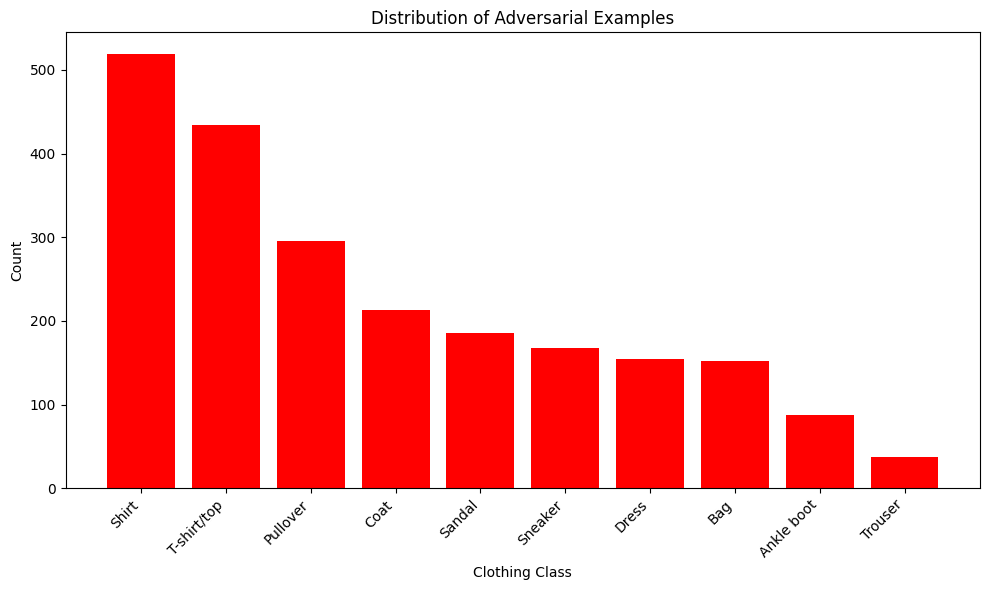

In [121]:
# Sort the oounter
sorted_counter = dict(sorted(adversarial_class_counter.items(), key=lambda item: item[1], reverse=True))
# Extract labels and counts
labels, counts = zip(*sorted_counter.items())

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='red')
plt.xlabel('Clothing Class')
plt.ylabel('Count')
plt.title('Distribution of Adversarial Examples')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()